In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import iv
from sympy import diff, lambdify, symbols, log, exp, sqrt
from scipy.stats import norm

alpha = 0.06
beta = 0.5
sigma = 0.15
T = 1
X = 0.06
# symbolic variables
y, x, t = symbols('y x t')

def p_CIR(y, x, t): # transition density of the true CIR model as benchmark, u-t:=t
  q = 2 * beta * alpha / sigma**2 - 1
  c = 2 * beta / (sigma**2 * (1 - np.exp(-beta * t)))
  z = c * x * np.exp(-beta * t)
  z0 = c * y
  return c * np.exp(-z - z0) * (z0 / z)**(q / 2) * iv(q, 2 * np.sqrt(z * z0))

def p_vasicek(y, x, t): # transition density of Vasicek model
  gamma_2 = sigma**2 * (1 - exp(-2 * beta * t)) / beta
  return 1 / (sqrt(np.pi * gamma_2)) * exp(-(y - alpha - (x - alpha) * exp(-beta * t))**2 / gamma_2)

def L(f): # infinitesimal generator of CIR model
  ft = diff(f, t)
  fx = diff(f, x)
  fx2 = diff(fx, x)
  return -ft + beta * (alpha - x) * fx + sigma**2 * x / 2 * fx2

D0 = sigma**2 * (x - 1) / 2 * diff(p_vasicek(y, x, t), x, 2) # 0-th order adjustment approximation expression

In [2]:
D_vasicek = [D0] # symbolic equations of adjustment terms
D_func = [] # used to save functions of adjustment terms
for _ in range(1, 5):
  D_vasicek.append(L(D_vasicek[-1]))
for i in range(0, 5):
  D_func.append(lambdify([y, x, t], D_vasicek[i]))

In [3]:
Y = np.arange(0, 0.2, 0.001)
P_true, P4_approx = [], []

for y in Y:
  P_true.append(p_CIR(y, X, T))
  p0 = p_vasicek(y, X, T)
  p0_approx = p0 + T * D_func[0](y, X, T)
  p1_approx = p0_approx + T**2 / 2 * D_func[1](y, X, T)
  p2_approx = p1_approx + T**3 / 6 * D_func[2](y, X, T)
  p3_approx = p2_approx + T**4 / 24 * D_func[3](y, X, T)
  p4_approx = p3_approx + T**5 / 120 * D_func[4](y, X, T)
  P4_approx.append(p4_approx)

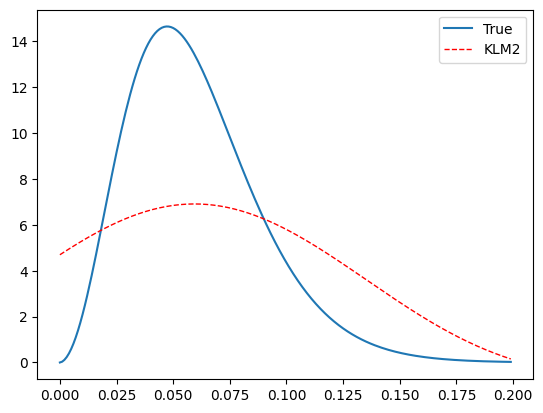

In [9]:
l1 = plt.plot(Y, P_true)
l2 = plt.plot(Y, P4_approx, color='red', linewidth=1.0, linestyle='--')
plt.legend(labels=['True', 'KLM2'], loc='best')
plt.show()